# MNIST Data Set - Quantum Neural Network

This notebook will showcase the usage of Tensorflow and Cirq to run binary classification with Quantum Computing. 
The data set used in this notebook is MNIST Data Set.

## Requirements

The requirements for running this notebook are the following:

* Python 3.6 or later
* Cirq
* Tensorflow
* Tensorflow-Quantum
* Pandas



```
    pip install cirq
    pip install -q tensorflow==2.1.0
    pip install tensorflow-quantum
    pip install pandas
    pip install -U scikit-learn
```



## MNIST Data Set 

For testing Tensorflow + Cirq we'll run a version of the [MNIST] experiment by Google. 
In this experiment, a similar approach than [Farhi et al] is executed over the MNIST data set. 


## What is the MNIST Data Set?

The [MNIST database] (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.The database is also widely used for training and testing in the field of machine learning.It was created by "re-mixing" the samples from NIST's original datasets. The creators felt that since NIST's training dataset was taken from American Census Bureau employees, while the testing dataset was taken from American high school students, it was not well-suited for machine learning experiments.Furthermore, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.


   [MNIST]: https://www.tensorflow.org/quantum/tutorials/mnist
   [Farhi et al]: https://arxiv.org/pdf/1802.06002.pdf
   [Iris Data Set]: https://archive.ics.uci.edu/ml/datasets/iris
   [Tensorflow]: https://www.tensorflow.org/
   [MNIST database]: https://en.wikipedia.org/wiki/MNIST_database

## Step 1. Ingestion of data set


In [64]:
# Libraries needed :
# 1. Pandas for data manipulation

import pandas as pd

# 2. SKLearn for data processing and training/test sets splitting.

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# 3. Cirq Libraries and SVGCircuit to show the circuits.

import cirq
from cirq.contrib.svg import SVGCircuit

# 4. Numpy to work with arrays of binary features

import numpy as np

# 5. Tensorflow and Tensorflow Quantum for the neural networks

import tensorflow as tf
import tensorflow_quantum as tfq

# 6. Sympy is a Python library for symbolic mathematics

import sympy

# 7. Matplotlib for visualizations

import matplotlib.pyplot as plt

# 8. Collections for operations with set of data

import collections

# 9. Seaborn for graphs

import seaborn as sns

In [27]:
# We can get our MNIST data set directly from Tensorflow and Keras libraries
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Step 2. Process the data 
Transform the data to a binary classification problem. 

To do this, We'll scale down the data to a range of [0,1] and will chose only two numbers: 1 and 8

In [28]:
# The next step is to transform each value to a range of [0,1]
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

In [29]:
# Once the data has been scaled down, we'll check how many members we have:

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [30]:
# This function has been adapted from the Tensorflow team and the Neural Network example
# Basically we'll adapt the classification problem to a binary problem (is the number a 1 or not)
# To limit the number of examples we'll keep only classes 1 and 5, and we'll transform class to is 1 or not.
def filter_15(x, y):
    keep = (y == 1) | (y == 5)
    x, y = x[keep], y[keep]
    y = y == 1
    return x,y

In [31]:
# Now we apply the function to limit the sample population
x_train, y_train = filter_15(x_train, y_train)
x_test, y_test = filter_15(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12163
Number of filtered test examples: 2027


False


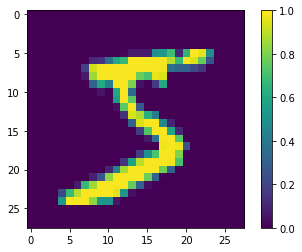

In [32]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [33]:
# One of the main problems we have right now is that a image size of 28X28 is too big for Quantum Computers
# So what we'll do is re-escale the image down to 4X4 

x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

False


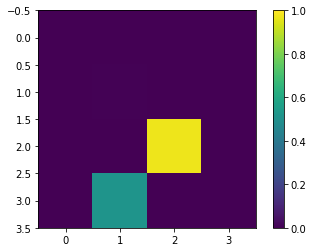

In [34]:
# Obviously re-escaling the image, we lose a lot of information
# But we still have enough information to try our Neural Network with Quantum Computing

print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [35]:
# Next step in our data preprocessing is to eliminate contradictory examples
# As commented in the example by Tensorflow team, this is not a typical step in ML feature engineering 
# or pre-processing but we'll executed to follow the paper in which this experiment is based

## THIS CODE AS ALL THE NOTEBOOK IS BASED IN THE MNIST EXAMPLE OF TENSORFLOW TEAM ##

def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
      labels = mapping[tuple(x.flatten())]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(list(labels)[0])
      else:
          # Throw out images that match more than one label.
          pass
    
    num_1 = sum(1 for value in mapping.values() if True in value)
    num_5 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 1s: ", num_1)
    print("Number of 5s: ", num_5)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

In [36]:
# Lets see how it looks our data set after removing contradicting images
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 6588
Number of 1s:  2176
Number of 5s:  4626
Number of contradictory images:  214

Initial number of examples:  12163
Remaining non-contradictory examples:  7949


## Step 3. Transform Data to Quantum Data (in Quantum Circuit)

In [37]:
# To transform the data to our Quantum Circuit we'll adapt the function used in the MNIST example
# Fist step is to transform our data to a binary coding
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)



In [38]:
# Once our data is in binary encoding, we'll create the circuites needed for our experiment

def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

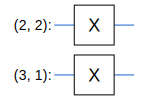

In [40]:
# Lets give it a look to how it looks the circuit for our first example
SVGCircuit(x_train_circ[0])

In [42]:
x_train_circ[0]

(2, 2): ───X───

(3, 1): ───X───

## Step 4. Transform Quantum Circuits to Tensors

In [43]:
# Convert the circuits to tensors we'll use in our neural networks
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [44]:
# For building our Quantum Neural Network, we'll base our code in the example of Tensorflow team at:
# https://www.tensorflow.org/quantum/tutorials/mnist 
#
# << There is little guidance for a quantum circuit structure that classifies images. 
#    Since the classification is based on the expectation of the readout qubit, Farhi et al. 
#    propose using two qubit gates, with the readout qubit always acted upon. 
#    This is similar in some ways to running small a Unitary RNN across the pixels. >>
#
# As we have adapted our experiment, we'll run an adapted process from the tutorial for classifying the iris dataset

class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)



In [45]:
# Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [46]:
# Get our model circuit
model_circuit, model_readout = create_quantum_model()

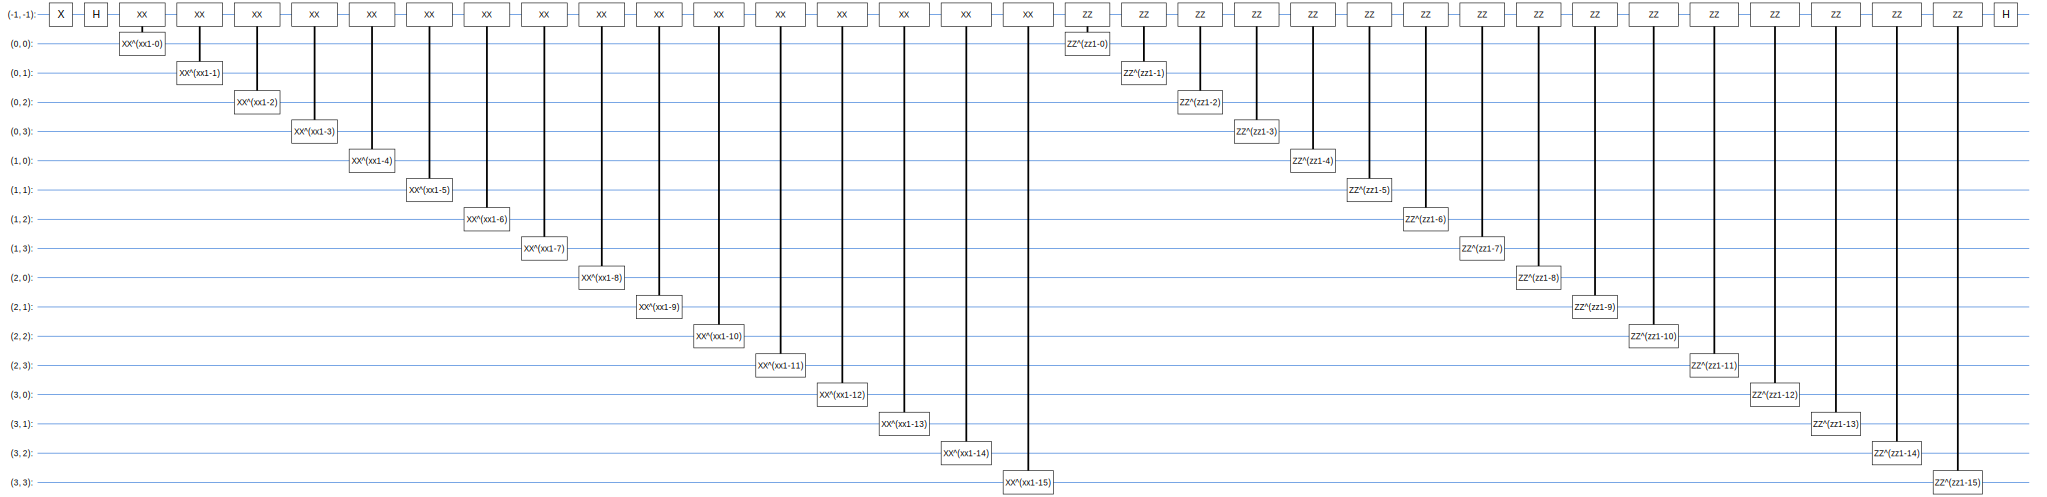

In [47]:
# Lets give it a look to how our circuit looks
SVGCircuit(model_circuit)

## Step 5. Build our model

In [49]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [50]:
# To use this model we'll need to transform the labels from Boolean to [-1,1]
# Easy transformation:

y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [51]:
# Next part of our model to adapt is the hinge function as we need a metric that works with [-1,1]
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [52]:
# Finally we compile our model and take a look to what it looks
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [53]:
# Quick summary of our model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_1 (PQC)                  (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


## Step 6. Train our model

In [54]:
# This model may take some time. 
# Using these variables we can adapt the size of the set we'll use for training (just for showcase purposes)

EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [55]:
# Get a subset of our sets just in case we just want to showcase the model
# Otherwise use the full length of the set (as I did in the cell before with the len)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [58]:
# Final step, we train our model and check how it looks
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
249/249 [==============================] - 223s 897ms/step - loss: 0.8114 - hinge_accuracy: 0.7003 - val_loss: 0.6590 - val_hinge_accuracy: 0.8580
Epoch 2/3
249/249 [==============================] - 225s 902ms/step - loss: 0.5063 - hinge_accuracy: 0.8069 - val_loss: 0.5540 - val_hinge_accuracy: 0.8590
Epoch 3/3
64/64 [==============================] - 8s 119ms/step - loss: 0.5603 - hinge_accuracy: 0.8531


## Step 7. Comparison with a classical Neural Network

### 7.1. Classical Model

In [59]:
# Lets create a classical model using neural networs
# The source for this code is the Tensorflow team experimenting with Quantum Computing (and comparing)

def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [60]:
## Lets keep in mind that this model has around 1.2M of parameters, so the comparison may not be very fair
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

64/64 [==============================] - 1s 12ms/step - loss: 0.0073 - accuracy: 0.9975


### 7.2. Fair Model

In [71]:
# As we can see this is faster and better performing, but as we said before this comparison may not be very fair
# Lets adapt a classical model to make a fair comparison (only 37 parameters)

def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=50,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Epoch 1/50
63/63 - 0s - loss: 0.3801 - accuracy: 0.8171 - val_loss: 0.4428 - val_accuracy: 0.6098
Epoch 2/50
63/63 - 0s - loss: 0.3756 - accuracy: 0.8171 - val_loss: 0.4372 - val_accuracy: 0.6098
Epoch 3/50
63/63 - 0s - loss: 0.3716 - accuracy: 0.8171 - val_loss: 0.4319 - val_accuracy: 0.6098
Epoch 4/50
63/63 - 0s - loss: 0.3679 - accuracy: 0.8171 - val_loss: 0.4265 - val_accuracy: 0.6098
Epoch 5/50
63/63 - 0s - loss: 0.3647 - accuracy: 0.8171 - val_loss: 0.4229 - val_accuracy: 0.6098
Epoch 6/50
63/63 - 0s - loss: 0.3616 - accuracy: 0.8171 - val_loss: 0.4182 - val_accuracy: 0.6098
Epoch 7/50
63/63 - 0s - loss: 0.3590 - accuracy: 0.8171 - val_loss: 0.4140 - val_accuracy: 0.6098
Epoch 8/50
63/63 - 0s - loss: 0.3565 - accuracy: 0.8171 - val_loss: 0.4107 - val_accuracy: 0.6098
Epoch 9/50
63/63 - 0s - loss: 0.3544 - accuracy: 0.8171 - val_loss: 0.4065 - val_accuracy: 0.6098
Epoch 10/50
63/63 - 0s - loss: 0.3523 - accuracy: 0.8171 - val_loss: 0.4034 - val_accuracy: 0.6098
Epoch 11/50
63/63 -

### 7.3. Comparison of three models

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

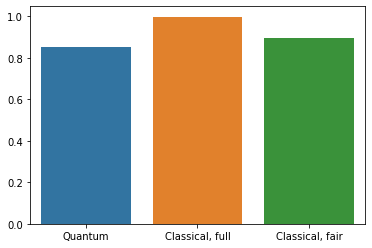

In [75]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])